<div align="center"> 
    <hr>
  <font size="6"><b>Clean-Clean Entity Resolution<br> with pyJedAI</b> </font>
   <hr>
</div>

In this notebook we present the pyJedAI approach in the well-known ABT-BUY dataset. pyJedAI is a an end-to-end and an upcoming python framework for Entity Resolution that will be a manual of the Entity Resolution. Its usages will outperform other state-of-the-art ER frameworks as it's easy-to-use and highly optimized as it is consisted from other established python libraries (i.e pandas, networkX, ..).

The bellow figure depicts pyJedAIs structure.
<div align="center"> 
<img src="https://github.com/Nikoletos-K/pyJedAI/blob/main/documentation/pyJedAIarchitecture.png?raw=true" alt="drawing" width="800"/>
</div>

__Abt-Buy dataset__

The Abt-Buy dataset for entity resolution derives from the online retailers Abt.com and Buy.com. The dataset contains 1076 entities from abt.com and 1076 entities from buy.com as well as a gold standard (perfect mapping) with 1076 matching record pairs between the two data sources. The common attributes between the two data sources are: product name, product description and product price.

In [3]:
import os
import sys
import pandas as pd
import networkx
from networkx import draw, Graph
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Import pyjedai

In [2]:
from pyjedai.utils import (
    cora_text_cleaning_method, 
    print_clusters,
    print_blocks, 
    print_candidate_pairs
)
from pyjedai.evaluation import Evaluation

# Data Reading

pyJedAI in order to perfrom needs only the tranformation of the initial data into a pandas DataFrame. Hence, pyJedAI can function in every structured or semi-structured data. In this case Abt-Buy dataset is provided as .csv files. 


In [6]:
from pyjedai.datamodel import Data

In [7]:
d1 = pd.read_csv("./data/D2/abt.csv", sep='|', engine='python', na_filter=False).astype(str)
d2 = pd.read_csv("./data/D2/buy.csv", sep='|', engine='python', na_filter=False).astype(str)
gt = pd.read_csv("./data/D2/gt.csv", sep='|', engine='python')

data = Data(
    dataset_1=d1,
    attributes_1=['id','name','description'],
    id_column_name_1='id',
    dataset_2=d2,
    attributes_2=['id','name','description'],
    id_column_name_2='id',
    ground_truth=gt,
)

data.process(cora_text_cleaning_method)

pyJedAI offers also dataset analysis methods (more will be developed)

In [8]:
data.print_specs()

Type of Entity Resolution:  Clean-Clean
Number of entities in D1:  1076
Attributes provided  for D1:  ['id', 'name', 'description']

Number of entities in D2:  1076
Attributes provided  for D2:  ['id', 'name', 'description']

Total number of entities:  2152
Number of matching pairs in ground-truth:  1076


In [17]:
data.dataset_1.head(5)

,id,name,description,price
0,0,sony turntable - pslx350h,sony turntable - pslx350h/ belt drive system/ ...,
1,1,bose acoustimass 5 series iii speaker system -...,bose acoustimass 5 series iii speaker system -...,399
2,2,sony switcher - sbv40s,sony switcher - sbv40s/ eliminates disconnecti...,49
3,3,sony 5 disc cd player - cdpce375,sony 5 disc cd player- cdpce375/ 5 disc change...,
4,4,bose 27028 161 bookshelf pair speakers in whit...,bose 161 bookshelf speakers in white - 161wh/ ...,158


In [78]:
data.dataset_2.head(5)

,id,name,description,price
0,0,linksys etherfast ezxs88w ethernet switch - ez...,linksys etherfast 8-port 10/100 switch (new/wo...,nan
1,1,linksys etherfast ezxs55w ethernet switch,5 x 10/100base-tx lan,nan
2,2,netgear prosafe fs105 ethernet switch - fs105na,netgear fs105 prosafe 5 port 10/100 desktop sw...,nan
3,3,belkin pro series high integrity vga/svga moni...,1 x hd-15 - 1 x hd-15 - 10ft - beige,nan
4,4,netgear prosafe jfs516 ethernet switch,netgear prosafe 16 port 10/100 rackmount switc...,nan


In [80]:
data.ground_truth.head(3)

,D1,D2
0,206,216
1,60,46
2,182,160


# Block Building

It clusters entities into overlapping blocks in a lazy manner that relies on unsupervised blocking keys: every token in an attribute value forms a key. Blocks are then extracted, possibly using a transformation, based on its equality or on its similarity with other keys.

The following methods are currently supported:

- Standard/Token Blocking
- Sorted Neighborhood
- Extended Sorted Neighborhood
- Q-Grams Blocking
- Extended Q-Grams Blocking
- Suffix Arrays Blocking
- Extended Suffix Arrays Blocking

In [9]:
from pyjedai.block_building import (
    StandardBlocking,
    QGramsBlocking,
    ExtendedQGramsBlocking,
    SuffixArraysBlocking,
    ExtendedSuffixArraysBlocking
)

In [10]:
qgb = ExtendedSuffixArraysBlocking()
blocks = qgb.build_blocks(data)

Extended Suffix Arrays Blocking:   0%|          | 0/2152 [00:00<?, ?it/s]

Evaluation is provided in each step

In [11]:
e = Evaluation(data)
e.report(blocks, qgb.execution_time)

+-----------------------------+
 > Evaluation
+-----------------------------+
Precision:      0.31% 
Recall:        98.88%
F1-score:       0.62%

Total execution time:  0:00:05.277246

True positives: 1064
False positives: 343844
True negatives: 813920
False negatives: 12

Total comparisons: 344908


# Block Cleaning

___Optional step___

Its goal is to clean a set of overlapping blocks from unnecessary comparisons, which can be either redundant (i.e., repeated comparisons that have already been executed in a previously examined block) or superfluous (i.e., comparisons that involve non-matching entities). Its methods operate on the coarse level of individual blocks or entities.

In [12]:
from pyjedai.block_cleaning import BlockFiltering

In [13]:
bf = BlockFiltering(ratio=0.8)
filtered_blocks = bf.process(blocks, data)

Block Filtering:   0%|                                                                                        …

In [14]:
Evaluation(data).report(filtered_blocks, bf.execution_time)

+-----------------------------+
 > Evaluation
+-----------------------------+
Precision:      0.67% 
Recall:        97.68%
F1-score:       1.33%

Total execution time:  0:00:00.757569

True positives: 1051
False positives: 156335
True negatives: 1001416
False negatives: 25

Total comparisons: 157386


# Comparison Cleaning

___Optional step___

Similar to Block Cleaning, this step aims to clean a set of blocks from both redundant and superfluous comparisons. Unlike Block Cleaning, its methods operate on the finer granularity of individual comparisons.

The following methods are currently supported:

- Comparison Propagation
- Cardinality Edge Pruning (CEP)
- Cardinality Node Pruning (CNP)
- Weighed Edge Pruning (WEP)
- Weighed Node Pruning (WNP)
- Reciprocal Cardinality Node Pruning (ReCNP)
- Reciprocal Weighed Node Pruning (ReWNP)
- BLAST

Most of these methods are Meta-blocking techniques. All methods are optional, but competive, in the sense that only one of them can part of an ER workflow. For more details on the functionality of these methods, see here. They can be combined with one of the following weighting schemes:

- Aggregate Reciprocal Comparisons Scheme (ARCS)
- Common Blocks Scheme (CBS)
- Enhanced Common Blocks Scheme (ECBS)
- Jaccard Scheme (JS)
- Enhanced Jaccard Scheme (EJS)

In [15]:
from pyjedai.block_cleaning import ComparisonsBasedBlockPurging

In [16]:
cbbp = ComparisonsBasedBlockPurging()
cleaned_blocks = cbbp.process(blocks, data)

Comparison-based Block Purging:   0%|          | 0/37602 [00:00<?, ?it/s]

In [14]:
e = Evaluation(data)
e.report(cleaned_blocks, cbbp.execution_time)

+-----------------------------+
 > Evaluation
+-----------------------------+
Precision:      0.31% 
Recall:        98.88%
F1-score:       0.62%

Total execution time:  0:00:00.151001

True positives: 1064
False positives: 343844
True negatives: 813920
False negatives: 12

Total comparisons: 344908


## Meta Blocking

In [21]:
from pyjedai.comparison_cleaning import (
    WeightedEdgePruning,
    WeightedNodePruning,
    CardinalityEdgePruning,
    CardinalityNodePruning,
    BLAST,
    ReciprocalCardinalityNodePruning,
    ReciprocalWeightedNodePruning,
    ComparisonPropagation
)

In [ ]:
wep = CardinalityEdgePruning(weighting_scheme='PEARSON_X2')
candidate_pairs_blocks = wep.process(filtered_blocks, data)

Cardinality Edge Pruning:   0%|          | 0/1076 [00:00<?, ?it/s]

[15, 47]
[18, 18145]
1853.590990218186
[12, 50]
[48, 18115]
629.3282005464057
[2, 60]
[41, 18122]
12.599962871483667
[2, 60]
[13, 18150]
41.31822312952266
[12, 50]
[60, 18103]
521.0005681639706
[12, 50]
[53, 18110]
579.3295990439184
[1, 61]
[16, 18147]
3.3953575836759167
[2, 60]
[35, 18128]
15.083135888113254
[2, 60]
[39, 18124]
13.346295170285144
[1, 61]
[71, 18092]
0.2675672968084152
[6, 56]
[94, 18069]
78.96095621005422
[1, 61]
[35, 18128]
1.1700837264258688
[2, 60]
[47, 18116]
10.729723864629037
[3, 59]
[42, 18121]
36.1918798805594
[1, 61]
[41, 18122]
0.8977083272942116
[1, 61]
[47, 18116]
0.698499817636748
[1, 61]
[61, 18102]
0.39891738262083515
[1, 61]
[38, 18125]
1.0226399685681975
[6, 56]
[13, 18150]
459.10538663466997
[24, 38]
[2, 18161]
6226.769704671148
[12, 50]
[25, 18138]
1033.4107230872014
[16, 46]
[28, 18135]
1583.3885768969799
[1, 61]
[41, 18122]
0.8977083272942116
[15, 47]
[16, 18147]
1974.8270360113254
[14, 48]
[22, 18141]
1469.1425531119426
[4, 42]
[77, 18102]
53.495

In [17]:
e = Evaluation(data)
e.report(candidate_pairs_blocks, wep.execution_time)

+-----------------------------+
 > Evaluation
+-----------------------------+
Precision:      3.48% 
Recall:        97.68%
F1-score:       6.73%

Total execution time:  0:00:00.550999

True positives: 1051
False positives: 29125
True negatives: 1128626
False negatives: 25

Total comparisons: 30176


# Entity Matching

It compares pairs of entity profiles, associating every pair with a similarity in [0,1]. Its output comprises the similarity graph, i.e., an undirected, weighted graph where the nodes correspond to entities and the edges connect pairs of compared entities.

In [18]:
from pyjedai.matching import EntityMatching

In [19]:
EM = EntityMatching(
    metric='sorensen_dice',
    similarity_threshold=0.5,
    attributes = ['description', 'name']
)

pairs_graph = EM.predict(candidate_pairs_blocks, data)

Entity Matching (sorensen_dice):   0%|          | 0/1076 [00:00<?, ?it/s]

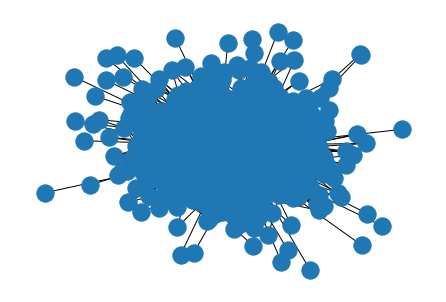

In [20]:
draw(pairs_graph)

# Entity Clustering

It takes as input the similarity graph produced by Entity Matching and partitions it into a set of equivalence clusters, with every cluster corresponding to a distinct real-world object.

In [21]:
from pyjedai.clustering import ConnectedComponentsClustering

In [22]:
ccc = ConnectedComponentsClustering()
clusters = ccc.process(pairs_graph)

In [23]:
e = Evaluation(data)
e.report(clusters, ccc.execution_time)

+-----------------------------+
 > Evaluation
+-----------------------------+
Precision:      0.09% 
Recall:        98.23%
F1-score:       0.19%

Total execution time:  0:00:00.003968

True positives: 1057
False positives: 1135218
True negatives: 22539
False negatives: 19

Total comparisons: 1136275


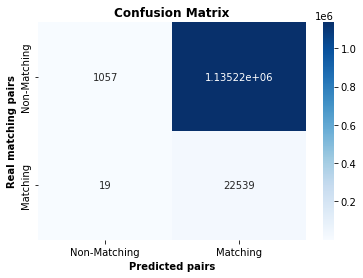

In [24]:
e.confusion_matrix()

# Overall Evaluation